# Install and import libraries

In [ ]:
!pip install timm
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.5 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd

import optuna
from optuna.trial import TrialState

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.utils.class_weight import compute_class_weight

import imblearn.metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Loading in the Plant Pathology 2021 - FGVC8 data set:


In [ ]:
# Install Kaggle
!pip install -q kaggle

In [ ]:
# Upload kaggle key:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hugomerkens","key":"b88ed1c0ea66e3cf84a3a1b1d040750f"}'}

In [ ]:
# Create a Kaggle folder
! mkdir ~/.kaggle

In [ ]:
# Copy the kaggle.json file to folder created
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [02:54<00:00, 126MB/s]
100% 14.9G/14.9G [02:55<00:00, 91.1MB/s]


In [ ]:
!unzip plant-pathology-2021-fgvc8.zip

Streaminguitvoer ingekort tot de laatste 5000 regels.
  inflating: train_images/e00c97b2de4749ce.jpg  
  inflating: train_images/e00df890cfe62736.jpg  
  inflating: train_images/e00ed0bf43a87f25.jpg  
  inflating: train_images/e00f759d65d52887.jpg  
  inflating: train_images/e00f934d9e50ad5b.jpg  
  inflating: train_images/e00fce341cb63da5.jpg  
  inflating: train_images/e010c7c35ecf3d1c.jpg  
  inflating: train_images/e01112939f783fec.jpg  
  inflating: train_images/e01592da4d71b8be.jpg  
  inflating: train_images/e0189acaf8cf80fd.jpg  
  inflating: train_images/e0189e4999bdd0fa.jpg  
  inflating: train_images/e01ae16d4a759cb5.jpg  
  inflating: train_images/e01dc39ccb2b4ccb.jpg  
  inflating: train_images/e01e42d90c66f3f3.jpg  
  inflating: train_images/e01e870bec65f40f.jpg  
  inflating: train_images/e01f17e0187fb80f.jpg  
  inflating: train_images/e01f503cb752e6c5.jpg  
  inflating: train_images/e024b69a784e9fc3.jpg  
  inflating: train_images/e026b4c23c9fcfc4.jpg  
  inflating: tr

In [ ]:
image_dir= '../content/train_images'
print(f"There are {len(os.listdir(image_dir))} images in the training set.")

image_labels = pd.read_csv('../content/train.csv')
print(f"There are {len(image_labels)} labels for the training set.")

There are 18632 images in the training set.
There are 18632 labels for the training set.


# Split the data

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import os
import shutil

In [ ]:
image_labels.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [ ]:
# Split the data into training, validation, and testing sets
train_df, test_df = train_test_split(image_labels, test_size=0.2, random_state=42, stratify=image_labels['labels'])

print(f'The training data contains {len(train_df)} images and it is {np.round((len(train_df)/ len(image_labels))*100, 2)}% of the dataset')
print(f'The validation data contains {len(test_df)} images and it is {np.round((len(test_df)/ len(image_labels))*100, 2)}% of the dataset')

The training data contains 14905 images and it is 80.0% of the dataset
The validation data contains 3727 images and it is 20.0% of the dataset


In [ ]:
import os
import shutil

# Assuming you have a list of labels in 'train_labels' DataFrame
labels = image_labels['labels'].unique()

# Create directories for train, validation, and test sets
# Define the directories for the images
train_dir = '../content/train_images'
test_dir = '../content/test_images'


# Create label directories within train and test
for label in labels:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

In [ ]:
# Check if all directories are created correctly
print("Train Directories:")
for label in labels:
    print(os.path.join(train_dir, label))

print("\nTest Directories:")
for label in labels:
    print(os.path.join(test_dir, label))

Train Directories:
../content/train_images/healthy
../content/train_images/scab frog_eye_leaf_spot complex
../content/train_images/scab
../content/train_images/complex
../content/train_images/rust
../content/train_images/frog_eye_leaf_spot
../content/train_images/powdery_mildew
../content/train_images/scab frog_eye_leaf_spot
../content/train_images/frog_eye_leaf_spot complex
../content/train_images/rust frog_eye_leaf_spot
../content/train_images/powdery_mildew complex
../content/train_images/rust complex

Test Directories:
../content/test_images/healthy
../content/test_images/scab frog_eye_leaf_spot complex
../content/test_images/scab
../content/test_images/complex
../content/test_images/rust
../content/test_images/frog_eye_leaf_spot
../content/test_images/powdery_mildew
../content/test_images/scab frog_eye_leaf_spot
../content/test_images/frog_eye_leaf_spot complex
../content/test_images/rust frog_eye_leaf_spot
../content/test_images/powdery_mildew complex
../content/test_images/rust 

In [ ]:
# Copy images to the respective directories
for image_name, label in zip(train_df['image'], train_df['labels']):
    source_path = os.path.join(image_dir, image_name)
    destination_path = os.path.join(train_dir, label, image_name)
    shutil.copy(source_path, destination_path)

for image_name, label in zip(test_df['image'], test_df['labels']):
    source_path = os.path.join(image_dir, image_name)
    destination_path = os.path.join(test_dir, label, image_name)
    shutil.copy(source_path, destination_path)

In [ ]:
import os

# Define the directories for the images
train_dir = '../content/train_images'
test_dir = '../content/test_images'

# Function to count the number of files in a directory
def count_files(directory):
    return len([file for file in os.listdir(directory) if os.path.isfile(os.path.join(directory, file))])

# Count the number of images in each directory
train_image_count = sum(count_files(os.path.join(train_dir, label)) for label in labels)
test_image_count = sum(count_files(os.path.join(test_dir, label)) for label in labels)

# Print the results
print(f'The training directory contains {train_image_count} images')
print(f'The test directory contains {test_image_count} images')

The training directory contains 14905 images
The test directory contains 3727 images


# Create insights in the data



## Show class distribution

In [ ]:
print(image_labels['labels'].value_counts())
print()

print(f"There are {len(image_labels['labels'].value_counts())} classes")

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

There are 12 classes


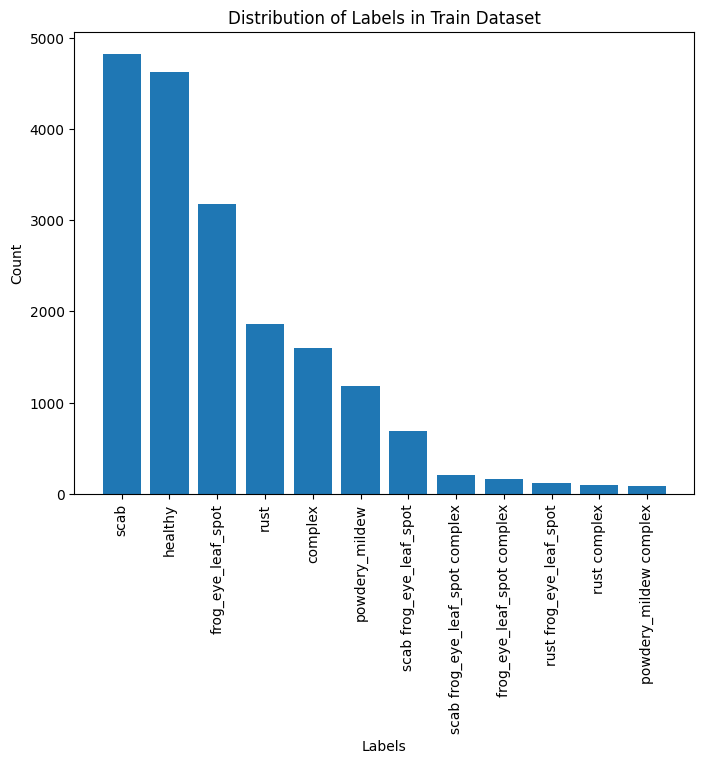

In [ ]:
import matplotlib.pyplot as plt

# Get the value counts of the 'labels' column
value_counts = image_labels['labels'].value_counts()

# Create a bar plot of the value counts
plt.figure(figsize=(8,6))
plt.bar(value_counts.index, value_counts.values)

# Set the title, x-axis label, and y-axis label
plt.title('Distribution of Labels in Train Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')

# Rotate the x-axis tick labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

## See some samples

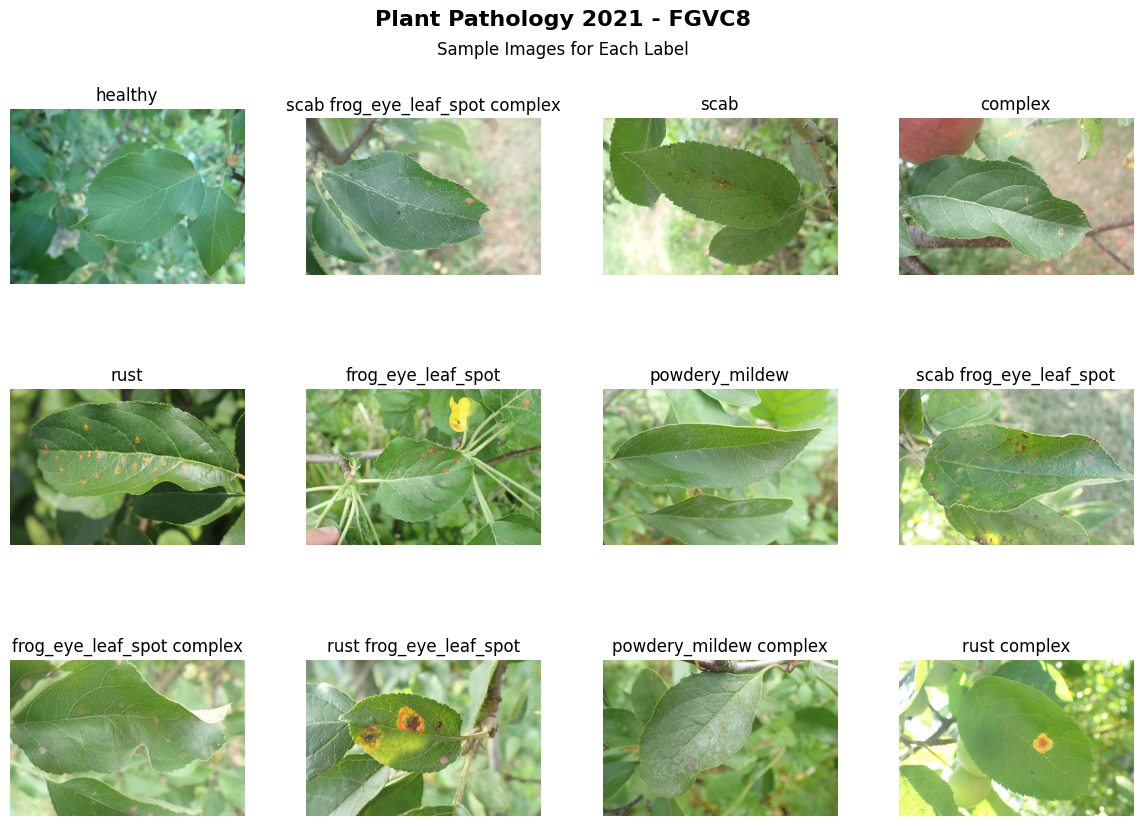

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the number of rows and columns for the grid
num_rows = 3
num_cols = 4

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 9))
fig.tight_layout()

# Iterate over the labels and plot an image for each label
for i, label in enumerate(labels):
    # Get the first image file for the label
    image_file = os.listdir(os.path.join(train_dir, label))[0]
    image_path = os.path.join(train_dir, label, image_file)

    # Load and plot the image
    img = mpimg.imread(image_path)
    row = i // num_cols
    col = i % num_cols
    axes[row, col].imshow(img)
    axes[row, col].set_title(label)
    axes[row, col].axis('off')

# Remove empty subplots if there are fewer labels than the grid size
if len(labels) < num_rows * num_cols:
    for i in range(len(labels), num_rows * num_cols):
        row = i // num_cols
        col = i % num_cols
        fig.delaxes(axes[row, col])

# Set the title and subtitle
title = "Plant Pathology 2021 - FGVC8"
subtitle = "Sample Images for Each Label"

# Add the title and subtitle to the figure
fig.suptitle(title, fontsize=16, fontweight='bold')
fig.subplots_adjust(top=0.9)
fig.text(0.5, 0.93, subtitle, ha='center', fontsize=12)

# Display the plot
plt.show()



# Train the best performing model form RQ1 on the domain related data set to create a domain-adaptive transfer learning model


In [ ]:
from torch.cuda.amp import autocast, GradScaler

from sklearn import metrics
from sklearn.metrics import f1_score

best_optimizer = 'RMSprop'
BATCHSIZE = 32
epochs = 20
best_lr = 0.001


# Set device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def define_model():
  model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=False, in_chans=3)

  for param in model.parameters():
    param.requires_grad = True

  num_in_features = model.classifier.in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=12))

  model.classifier = nn.Sequential(*head)

  for param in model.classifier.parameters():
    param.requires_grad = True


  return model

def get_dataset():
  import torchvision.transforms as transforms
  from torchvision.datasets import ImageFolder

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_dir, transform=transform_train)
  test_dataset = ImageFolder(test_dir, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False, num_workers= 2)

  return train_loader, test_loader


# Generate the model.
model = define_model().to(DEVICE)

# Generate the optimizers.
optimizer_name = best_optimizer
lr = best_lr
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

# Generate a loss function
criterion = nn.CrossEntropyLoss()

# Get the FashionMNIST dataset.
train_loader, test_loader = get_dataset()

# Initialize GradScaler
scaler = GradScaler()

for epoch in range(epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        # Compute the train accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Compute the train loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100.0 * correct_train / total_train

    # Evaluate the model on the validation set
    model.eval()
    correct_valid = 0
    total_valid = 0
    y_true, y_pred = [], []
    valid_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)

            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

            y_true += labels.cpu().tolist()
            y_pred += predicted.cpu().tolist()

    # Compute the validation loss and accuracy
    valid_loss /= len(test_loader)
    valid_accuracy = 100.0 * correct_valid / total_valid

    #calculate the macro f1-score
    f1_score = metrics.f1_score(y_true, y_pred, average='macro')

    # Print the results for this epoch
    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}% - "
          f"Test Loss: {valid_loss:.4f}, Test Accuracy: {valid_accuracy:.2f}%, Macro F1 score: {f1_score:.4f}")

Epoch 0/20 - Train Loss: 1.5773, Train_Val Accuracy: 40.07% - Test Loss: 1.2208, Test Accuracy: 54.92%, Macro F1 score: 0.2690
Epoch 1/20 - Train Loss: 3.3654, Train_Val Accuracy: 29.04% - Test Loss: 1.6931, Test Accuracy: 36.54%, Macro F1 score: 0.1334
Epoch 2/20 - Train Loss: 1.3828, Train_Val Accuracy: 48.06% - Test Loss: 1.7114, Test Accuracy: 43.25%, Macro F1 score: 0.2246
Epoch 3/20 - Train Loss: 1.1244, Train_Val Accuracy: 60.07% - Test Loss: 1.1260, Test Accuracy: 61.95%, Macro F1 score: 0.3063
Epoch 4/20 - Train Loss: 0.9756, Train_Val Accuracy: 67.07% - Test Loss: 0.8578, Test Accuracy: 71.96%, Macro F1 score: 0.3634
Epoch 5/20 - Train Loss: 0.8666, Train_Val Accuracy: 71.57% - Test Loss: 0.9595, Test Accuracy: 66.92%, Macro F1 score: 0.3415
Epoch 6/20 - Train Loss: 0.7845, Train_Val Accuracy: 74.55% - Test Loss: 0.9558, Test Accuracy: 69.12%, Macro F1 score: 0.3747
Epoch 7/20 - Train Loss: 0.7299, Train_Val Accuracy: 76.53% - Test Loss: 0.7135, Test Accuracy: 78.43%, Macro F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save the weights of the model
torch.save(model.state_dict(), '/content/drive/MyDrive/Thesis code 2/model_weights.pth')

# Use created domain adaptation model:

# Prepare dataset, weights and model

## Load in the dataset

In [ ]:
from google.colab import drive

# Mount Google Drive to access files and folders
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/'
train_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/training/'
val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/validation/'
train_val_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/train_val'
test_path = '/content/drive/MyDrive/Thesis code 2/healthy_scab_FDs/test/'

## Calculating pos weight

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train
train_dataset = ImageFolder(train_path)
train_targets = train_dataset.targets
train_class_counts = torch.bincount(torch.tensor(train_targets))

train_total_negative_samples = train_class_counts[0].item()
train_total_positive_samples = train_class_counts[1].item()

train_pos_weight = train_total_negative_samples / train_total_positive_samples

# Put class weight in tensor
train_pos_weight_tensor = torch.tensor(train_pos_weight)
train_pos_weight_tensor = train_pos_weight_tensor.to(DEVICE)
print(train_pos_weight_tensor)

tensor(0.8710, device='cuda:0')


In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate class weight train_val dataset
train_val_dataset = ImageFolder(train_val_path)
train_val_targets = train_val_dataset.targets
train_val_class_counts = torch.bincount(torch.tensor(train_val_targets))

train_val_total_negative_samples = train_val_class_counts[0].item()
train_val_total_positive_samples = train_val_class_counts[1].item()

train_val_pos_weight = train_val_total_negative_samples / train_val_total_positive_samples

# Put class weight in tensor
train_val_pos_weight_tensor = torch.tensor(train_val_pos_weight)
train_val_pos_weight_tensor = train_val_pos_weight_tensor.to(DEVICE)
print(train_val_pos_weight_tensor)

tensor(0.8727, device='cuda:0')


## load in achitecture previous model to load in weights

In [ ]:
# load in achitecture previous model to load in weights
def define_model():
  model = timm.create_model('tf_efficientnetv2_b0.in1k', pretrained=False, in_chans=3)

  for param in model.parameters():
    param.requires_grad = True

  num_in_features = model.classifier.in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=12))

  model.classifier = nn.Sequential(*head)

  for param in model.classifier.parameters():
    param.requires_grad = True

  return model

# Do hyperparameter tuning Domain adoptation model

In [ ]:
# Set device and parameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCHSIZE = 32
epochs = 100

def tl_model(trial):
  model_achitecture_tf = define_model().to(DEVICE)
  loaded_model = model_achitecture_tf
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis code 2/model_weights.pth'))

  for param in loaded_model.parameters():
      param.requires_grad = False

  num_in_features = loaded_model.classifier[0].in_features

  head = []
  first_neuron = trial.suggest_categorical('first_neuron', [128, 256, 512, 768])
  head.append(nn.Linear(in_features=num_in_features, out_features=first_neuron))
  head.append(nn.ReLU())
  drop_out = trial.suggest_categorical('drop_out', [0, 0.3, 0.5])
  head.append(nn.Dropout(p=drop_out))
  num_in_features = first_neuron

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  loaded_model.classifier = nn.Sequential(*head)

  for param in loaded_model.classifier.parameters():
    param.requires_grad = True

  return loaded_model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_dataset = ImageFolder(train_path, transform=transform_train)
  val_dataset = ImageFolder(val_path, transform=transform_valid)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_loader, valid_loader


def objective(trial):

  # Send model to the device
  model = tl_model(trial).to(DEVICE)

  # Define optimizer and loss function
  optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "AdamW"])
  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weightdecay = trial.suggest_float("weightdecay", low=0.001, high=0.01, log=True)

  if optimizer_name == 'RMSprop':
    optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weightdecay)
  elif optimizer_name == 'AdamW':
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weightdecay)


  use_pos_weight = trial.suggest_categorical("use_pos_weight", [True, False])

  if use_pos_weight is True:
    criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
  else:
    criterion = nn.BCEWithLogitsLoss()

  # Load in dataset
  train_loader, valid_loader = get_dataset()

  # Initialize variables for early stopping
  best_loss = 1000000
  patience = 5
  no_improvement_count = 0


  # Training
  for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    y_true = []
    y_pred = []


    for i in train_loader:
        #LOADING THE DATA IN A BATCH
        data, target = i

        # moving the tensors to the configured device
        data, target = data.to(DEVICE), target.to(DEVICE)

        #FORWARD PASS
        target = target.float()
        output = model(data.float())
        loss = criterion(output, target.unsqueeze(1))

        train_loss += loss.item() * data.size(0)

        #BACKWARD AND OPTIMIZE
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #PREDICTIONS BCELogitsloss()
        pred = torch.round(torch.sigmoid(output.detach()))
        y_true.extend(target.tolist())
        y_pred.extend(pred.reshape(-1).tolist())

    train_loss /= len(train_loader.sampler)
    train_accuracy = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    train_specificity = tn / (tn + fp)
    train_sensitivity = tp / (tp + fn)

    train_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


    # Evaluation:

    #model in eval mode skips Dropout etc
    model.eval()
    valid_loss = 0.0
    y_true = []
    y_pred = []

    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i in valid_loader:

            #LOAD THE DATA IN A BATCH
            data, target = i

            # moving the tensors to the configured device
            data, target = data.to(DEVICE), target.to(DEVICE)

            target = target.float()
            output = model(data.float())

            loss = criterion(output, target.unsqueeze(1))
            valid_loss += loss.item() * data.size(0)


            #PREDICTIONS
            pred = torch.round(torch.sigmoid(output))
            y_true.extend(target.tolist())
            y_pred.extend(pred.reshape(-1).tolist())

    valid_loss /= len(valid_loader.sampler)
    valid_accuracy = accuracy_score(y_true,y_pred)

    # get the specificity, sensitivity and g-mean
    cm = confusion_matrix(y_true, y_pred)

    # Extract the elements of the confusion matrix
    tn, fp, fn, tp = cm.ravel()

    # Calculate specificity and sensitivity
    valid_specificity = tn / (tn + fp)
    valid_sensitivity = tp / (tp + fn)

    valid_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}% "
          f"Train specificity: {train_specificity:.4f}, Train sensitivity: {train_sensitivity:.4f} Train g_mean: {train_gmean:.4f}% ----> "
          f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f} %"
          f"Valid specificity: {valid_specificity:.4f}, Valid sensitivity: {valid_sensitivity:.4f} Valid g_mean: {valid_gmean:.4f}")

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    if no_improvement_count >= patience:
        print("Early stopping criterion met at epoch {}".format(epoch))
        break

    # Pruning
    if trial.should_prune():
        raise optuna.TrialPruned()

    # Report the intermediate result
    trial.report(valid_gmean, epoch)

  return valid_gmean


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-06-22 16:06:52,575] A new study created in memory with name: no-name-fea499ca-71c7-4d68-aaf9-dd8e8716d8c6


Epoch [1/100], Train Loss: 0.7425, Train Accuracy: 0.5431% Train specificity: 0.4722, Train sensitivity: 0.6048 Train g_mean: 0.5344% ----> Valid Loss: 0.7951, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6257, Train Accuracy: 0.6034% Train specificity: 0.6296, Train sensitivity: 0.5806 Train g_mean: 0.6046% ----> Valid Loss: 0.6226, Valid Accuracy: 0.5085 %Valid specificity: 0.6667, Valid sensitivity: 0.4390 Valid g_mean: 0.5410
Epoch [3/100], Train Loss: 0.5539, Train Accuracy: 0.6422% Train specificity: 0.6667, Train sensitivity: 0.6210 Train g_mean: 0.6434% ----> Valid Loss: 0.6711, Valid Accuracy: 0.3898 %Valid specificity: 0.8333, Valid sensitivity: 0.1951 Valid g_mean: 0.4032
Epoch [4/100], Train Loss: 0.5972, Train Accuracy: 0.6681% Train specificity: 0.6481, Train sensitivity: 0.6855 Train g_mean: 0.6666% ----> Valid Loss: 0.5724, Valid Accuracy: 0.7458 %Valid specificity: 0.4444, Valid sensitivi

[I 2023-06-22 16:31:00,153] Trial 0 finished with value: 0.47995031359822576 and parameters: {'first_neuron': 256, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.001630747593064658, 'weightdecay': 0.004883478034023159, 'use_pos_weight': True}. Best is trial 0 with value: 0.47995031359822576.


Epoch [17/100], Train Loss: 0.5698, Train Accuracy: 0.6681% Train specificity: 0.6389, Train sensitivity: 0.6935 Train g_mean: 0.6657% ----> Valid Loss: 0.5502, Valid Accuracy: 0.6610 %Valid specificity: 0.2778, Valid sensitivity: 0.8293 Valid g_mean: 0.4800
Early stopping criterion met at epoch 16
Epoch [1/100], Train Loss: 0.7044, Train Accuracy: 0.5690% Train specificity: 0.4722, Train sensitivity: 0.6532 Train g_mean: 0.5554% ----> Valid Loss: 0.6885, Valid Accuracy: 0.5593 %Valid specificity: 0.6667, Valid sensitivity: 0.5122 Valid g_mean: 0.5843
Epoch [2/100], Train Loss: 0.5974, Train Accuracy: 0.6767% Train specificity: 0.5370, Train sensitivity: 0.7984 Train g_mean: 0.6548% ----> Valid Loss: 0.6725, Valid Accuracy: 0.5424 %Valid specificity: 0.6667, Valid sensitivity: 0.4878 Valid g_mean: 0.5703
Epoch [3/100], Train Loss: 0.6272, Train Accuracy: 0.6250% Train specificity: 0.6667, Train sensitivity: 0.5887 Train g_mean: 0.6265% ----> Valid Loss: 0.6777, Valid Accuracy: 0.5254 %

[I 2023-06-22 16:46:22,221] Trial 1 finished with value: 0.6070944618729909 and parameters: {'first_neuron': 768, 'drop_out': 0, 'optimizer': 'AdamW', 'lr': 0.003491777261309429, 'weightdecay': 0.00770510086472761, 'use_pos_weight': False}. Best is trial 1 with value: 0.6070944618729909.


Epoch [12/100], Train Loss: 0.5598, Train Accuracy: 0.7284% Train specificity: 0.6759, Train sensitivity: 0.7742 Train g_mean: 0.7234% ----> Valid Loss: 0.5746, Valid Accuracy: 0.7119 %Valid specificity: 0.4444, Valid sensitivity: 0.8293 Valid g_mean: 0.6071
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.6748, Train Accuracy: 0.5905% Train specificity: 0.3981, Train sensitivity: 0.7581 Train g_mean: 0.5494% ----> Valid Loss: 0.6586, Valid Accuracy: 0.6780 %Valid specificity: 0.0556, Valid sensitivity: 0.9512 Valid g_mean: 0.2299
Epoch [2/100], Train Loss: 0.6620, Train Accuracy: 0.6552% Train specificity: 0.4167, Train sensitivity: 0.8629 Train g_mean: 0.5996% ----> Valid Loss: 0.6316, Valid Accuracy: 0.7119 %Valid specificity: 0.0556, Valid sensitivity: 1.0000 Valid g_mean: 0.2357
Epoch [3/100], Train Loss: 0.6548, Train Accuracy: 0.6509% Train specificity: 0.4537, Train sensitivity: 0.8226 Train g_mean: 0.6109% ----> Valid Loss: 0.6501, Valid Accuracy: 0.6780 %

[I 2023-06-22 17:07:35,523] Trial 2 finished with value: 0.5334349496690813 and parameters: {'first_neuron': 768, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.00018832739693412501, 'weightdecay': 0.006736867503944584, 'use_pos_weight': False}. Best is trial 1 with value: 0.6070944618729909.


Epoch [16/100], Train Loss: 0.5736, Train Accuracy: 0.7716% Train specificity: 0.7130, Train sensitivity: 0.8226 Train g_mean: 0.7658% ----> Valid Loss: 0.6274, Valid Accuracy: 0.6271 %Valid specificity: 0.3889, Valid sensitivity: 0.7317 Valid g_mean: 0.5334
Early stopping criterion met at epoch 15
Epoch [1/100], Train Loss: 16.9513, Train Accuracy: 0.5129% Train specificity: 0.5556, Train sensitivity: 0.4758 Train g_mean: 0.5141% ----> Valid Loss: 3.3275, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 1.2487, Train Accuracy: 0.6034% Train specificity: 0.5926, Train sensitivity: 0.6129 Train g_mean: 0.6027% ----> Valid Loss: 1.4165, Valid Accuracy: 0.6949 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.8011, Train Accuracy: 0.6250% Train specificity: 0.5370, Train sensitivity: 0.7016 Train g_mean: 0.6138% ----> Valid Loss: 0.6330, Valid Accuracy: 0.6949 

[I 2023-06-22 17:34:57,976] Trial 3 finished with value: 0.21464030540559487 and parameters: {'first_neuron': 768, 'drop_out': 0, 'optimizer': 'RMSprop', 'lr': 0.006284967078851058, 'weightdecay': 0.005779495477716389, 'use_pos_weight': True}. Best is trial 1 with value: 0.6070944618729909.


Epoch [20/100], Train Loss: 0.6059, Train Accuracy: 0.6595% Train specificity: 0.6204, Train sensitivity: 0.6935 Train g_mean: 0.6559% ----> Valid Loss: 1.2889, Valid Accuracy: 0.3220 %Valid specificity: 0.9444, Valid sensitivity: 0.0488 Valid g_mean: 0.2146
Early stopping criterion met at epoch 19
Epoch [1/100], Train Loss: 0.6160, Train Accuracy: 0.5991% Train specificity: 0.4815, Train sensitivity: 0.7016 Train g_mean: 0.5812% ----> Valid Loss: 1.0314, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000
Epoch [2/100], Train Loss: 0.6166, Train Accuracy: 0.6293% Train specificity: 0.6204, Train sensitivity: 0.6371 Train g_mean: 0.6287% ----> Valid Loss: 0.7826, Valid Accuracy: 0.3220 %Valid specificity: 1.0000, Valid sensitivity: 0.0244 Valid g_mean: 0.1562
Epoch [3/100], Train Loss: 0.5612, Train Accuracy: 0.6681% Train specificity: 0.5648, Train sensitivity: 0.7581 Train g_mean: 0.6543% ----> Valid Loss: 1.3314, Valid Accuracy: 0.3051 %

[I 2023-06-22 17:51:59,641] Trial 4 finished with value: 0.5796924705683215 and parameters: {'first_neuron': 128, 'drop_out': 0.3, 'optimizer': 'AdamW', 'lr': 0.007893818726702516, 'weightdecay': 0.008188211993899986, 'use_pos_weight': True}. Best is trial 1 with value: 0.6070944618729909.


Epoch [13/100], Train Loss: 0.6033, Train Accuracy: 0.6552% Train specificity: 0.7593, Train sensitivity: 0.5645 Train g_mean: 0.6547% ----> Valid Loss: 0.5813, Valid Accuracy: 0.6610 %Valid specificity: 0.4444, Valid sensitivity: 0.7561 Valid g_mean: 0.5797
Early stopping criterion met at epoch 12
Epoch [1/100], Train Loss: 0.6798, Train Accuracy: 0.6164% Train specificity: 0.6296, Train sensitivity: 0.6048 Train g_mean: 0.6171% ----> Valid Loss: 0.6718, Valid Accuracy: 0.6610 %Valid specificity: 0.5000, Valid sensitivity: 0.7317 Valid g_mean: 0.6049
Epoch [2/100], Train Loss: 0.6518, Train Accuracy: 0.6078% Train specificity: 0.3241, Train sensitivity: 0.8548 Train g_mean: 0.5263% ----> Valid Loss: 0.6293, Valid Accuracy: 0.6949 %Valid specificity: 0.0000, Valid sensitivity: 1.0000 Valid g_mean: 0.0000
Epoch [3/100], Train Loss: 0.6347, Train Accuracy: 0.6897% Train specificity: 0.4537, Train sensitivity: 0.8952 Train g_mean: 0.6373% ----> Valid Loss: 0.6278, Valid Accuracy: 0.7458 %

[I 2023-06-22 17:58:27,215] Trial 5 pruned. 


Epoch [5/100], Train Loss: 0.6338, Train Accuracy: 0.6810% Train specificity: 0.5556, Train sensitivity: 0.7903 Train g_mean: 0.6626% ----> Valid Loss: 0.6082, Valid Accuracy: 0.6949 %Valid specificity: 0.2222, Valid sensitivity: 0.9024 Valid g_mean: 0.4478
Epoch [1/100], Train Loss: 0.6694, Train Accuracy: 0.5819% Train specificity: 0.3796, Train sensitivity: 0.7581 Train g_mean: 0.5365% ----> Valid Loss: 0.6518, Valid Accuracy: 0.6949 %Valid specificity: 0.5556, Valid sensitivity: 0.7561 Valid g_mean: 0.6481
Epoch [2/100], Train Loss: 0.6032, Train Accuracy: 0.6897% Train specificity: 0.5370, Train sensitivity: 0.8226 Train g_mean: 0.6646% ----> Valid Loss: 0.7152, Valid Accuracy: 0.4407 %Valid specificity: 0.8333, Valid sensitivity: 0.2683 Valid g_mean: 0.4728
Epoch [3/100], Train Loss: 0.5681, Train Accuracy: 0.7069% Train specificity: 0.6389, Train sensitivity: 0.7661 Train g_mean: 0.6996% ----> Valid Loss: 0.7995, Valid Accuracy: 0.3559 %Valid specificity: 0.7778, Valid sensitivi

[I 2023-06-22 18:13:56,640] Trial 6 finished with value: 0.6343808196897538 and parameters: {'first_neuron': 768, 'drop_out': 0, 'optimizer': 'Adam', 'lr': 0.0012358681647118, 'weightdecay': 0.0010291865174173523, 'use_pos_weight': False}. Best is trial 6 with value: 0.6343808196897538.


Epoch [12/100], Train Loss: 0.5901, Train Accuracy: 0.7198% Train specificity: 0.6574, Train sensitivity: 0.7742 Train g_mean: 0.7134% ----> Valid Loss: 0.6132, Valid Accuracy: 0.7119 %Valid specificity: 0.5000, Valid sensitivity: 0.8049 Valid g_mean: 0.6344
Early stopping criterion met at epoch 11
Epoch [1/100], Train Loss: 0.6341, Train Accuracy: 0.5647% Train specificity: 0.4352, Train sensitivity: 0.6774 Train g_mean: 0.5430% ----> Valid Loss: 0.6903, Valid Accuracy: 0.3390 %Valid specificity: 1.0000, Valid sensitivity: 0.0488 Valid g_mean: 0.2209
Epoch [2/100], Train Loss: 0.5895, Train Accuracy: 0.6379% Train specificity: 0.7037, Train sensitivity: 0.5806 Train g_mean: 0.6392% ----> Valid Loss: 0.6156, Valid Accuracy: 0.5085 %Valid specificity: 0.7222, Valid sensitivity: 0.4146 Valid g_mean: 0.5472
Epoch [3/100], Train Loss: 0.5963, Train Accuracy: 0.6509% Train specificity: 0.5370, Train sensitivity: 0.7500 Train g_mean: 0.6346% ----> Valid Loss: 0.6645, Valid Accuracy: 0.3898 %

[I 2023-06-22 18:20:43,649] Trial 7 pruned. 


Epoch [5/100], Train Loss: 0.5564, Train Accuracy: 0.6897% Train specificity: 0.6944, Train sensitivity: 0.6855 Train g_mean: 0.6899% ----> Valid Loss: 0.6234, Valid Accuracy: 0.6102 %Valid specificity: 0.6667, Valid sensitivity: 0.5854 Valid g_mean: 0.6247
Epoch [1/100], Train Loss: 0.6731, Train Accuracy: 0.6121% Train specificity: 0.5370, Train sensitivity: 0.6774 Train g_mean: 0.6032% ----> Valid Loss: 0.7309, Valid Accuracy: 0.4407 %Valid specificity: 0.9444, Valid sensitivity: 0.2195 Valid g_mean: 0.4553
Epoch [2/100], Train Loss: 0.6633, Train Accuracy: 0.6250% Train specificity: 0.3704, Train sensitivity: 0.8468 Train g_mean: 0.5600% ----> Valid Loss: 0.8160, Valid Accuracy: 0.3559 %Valid specificity: 1.0000, Valid sensitivity: 0.0732 Valid g_mean: 0.2705
Epoch [3/100], Train Loss: 0.6100, Train Accuracy: 0.6897% Train specificity: 0.6667, Train sensitivity: 0.7097 Train g_mean: 0.6878% ----> Valid Loss: 0.7107, Valid Accuracy: 0.4746 %Valid specificity: 0.6667, Valid sensitivi

[I 2023-06-22 18:27:05,056] Trial 8 pruned. 


Epoch [5/100], Train Loss: 0.5978, Train Accuracy: 0.6724% Train specificity: 0.6111, Train sensitivity: 0.7258 Train g_mean: 0.6660% ----> Valid Loss: 0.5919, Valid Accuracy: 0.6780 %Valid specificity: 0.3889, Valid sensitivity: 0.8049 Valid g_mean: 0.5595
Epoch [1/100], Train Loss: 0.6730, Train Accuracy: 0.5560% Train specificity: 0.3611, Train sensitivity: 0.7258 Train g_mean: 0.5120% ----> Valid Loss: 0.7222, Valid Accuracy: 0.3729 %Valid specificity: 1.0000, Valid sensitivity: 0.0976 Valid g_mean: 0.3123
Epoch [2/100], Train Loss: 0.6405, Train Accuracy: 0.6552% Train specificity: 0.4352, Train sensitivity: 0.8468 Train g_mean: 0.6070% ----> Valid Loss: 0.7754, Valid Accuracy: 0.3051 %Valid specificity: 1.0000, Valid sensitivity: 0.0000 Valid g_mean: 0.0000


[I 2023-06-22 18:30:53,685] Trial 9 pruned. 


Epoch [3/100], Train Loss: 0.6333, Train Accuracy: 0.6552% Train specificity: 0.5741, Train sensitivity: 0.7258 Train g_mean: 0.6455% ----> Valid Loss: 0.8032, Valid Accuracy: 0.3220 %Valid specificity: 1.0000, Valid sensitivity: 0.0244 Valid g_mean: 0.1562
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  4
  Number of complete trials:  6
Best trial:
  Value:  0.6343808196897538
  Params: 
    first_neuron: 768
    drop_out: 0
    optimizer: Adam
    lr: 0.0012358681647118
    weightdecay: 0.0010291865174173523
    use_pos_weight: False


In [ ]:
trials_df = study.trials_dataframe()
trials_df

,number,value,datetime_start,datetime_complete,duration,params_drop_out,params_first_neuron,params_lr,params_optimizer,params_use_pos_weight,params_weightdecay,state
0,0,0.479950,2023-06-22 16:06:52.577969,2023-06-22 16:31:00.152470,0 days 00:24:07.574501,0.0,256,0.001631,RMSprop,True,0.004883,COMPLETE
1,1,0.607094,2023-06-22 16:31:00.154325,2023-06-22 16:46:22.221166,0 days 00:15:22.066841,0.0,768,0.003492,AdamW,False,0.007705,COMPLETE
2,2,0.533435,2023-06-22 16:46:22.222751,2023-06-22 17:07:35.522898,0 days 00:21:13.300147,0.0,768,0.000188,Adam,False,0.006737,COMPLETE
3,3,0.214640,2023-06-22 17:07:35.524385,2023-06-22 17:34:57.975969,0 days 00:27:22.451584,0.0,768,0.006285,RMSprop,True,0.005779,COMPLETE
4,4,0.579692,2023-06-22 17:34:57.977716,2023-06-22 17:51:59.641572,0 days 00:17:01.663856,0.3,128,0.007894,AdamW,True,0.008188,COMPLETE
5,5,0.576176,2023-06-22 17:51:59.642980,2023-06-22 17:58:27.215493,0 days 00:06:27.572513,0.5,768,0.000233,AdamW,False,0.002344,PRUNED
6,6,0.634381,2023-06-22 17:58:27.220702,2023-06-22 18:13:56.640096,0 days 00:15:29.419394,0.0,768,0.001236,Adam,False,0.001029,COMPLETE
7,7,0.570266,2023-06-22 18:13:56.641699,2023-06-22 18:20:43.649296,0 days 00:06:47.007597,0.3,512,0.000972,Adam,True,0.001324,PRUNED
8,8,0.510061,2023-06-22 18:20:43.650779,2023-06-22 18:27:05.056030,0 days 00:06:21.405251,0.0,512,0.002179,Adam,False,0.001660,PRUNED
9,9,0.000000,2023-06-22 18:27:05.057361,2023-06-22 18:30:53.685201,0 days 00:03:48.627840,0.0,256,0.000156,RMSprop,False,0.005273,PRUNED


In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

NameError: ignored

In [ ]:
from google.colab import runtime
runtime.unassign()

# Train the Domain adoptation model with the best hyperparameters (on combined training and validation dataset

In [ ]:
BATCHSIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_neurons = 768
best_dropout = 0.0
best_optimizer = 'Adam'
best_lr = 0.001236
epochs = 12
weight_decay = 0.001029
use_pos_weight = False



def tl_model():
  model_achitecture_tf = define_model().to(DEVICE)
  loaded_model = model_achitecture_tf
  loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/Thesis code 2/model_weights.pth'))

  for param in loaded_model.parameters():
      param.requires_grad = False

  num_in_features = loaded_model.classifier[0].in_features

  head = []
  head.append(nn.Linear(in_features=num_in_features, out_features=best_neurons))
  head.append(nn.ReLU())
  head.append(nn.Dropout(p=best_dropout))
  num_in_features = best_neurons

  head.append(nn.Linear(in_features=num_in_features, out_features=1))

  loaded_model.classifier = nn.Sequential(*head)

  for param in loaded_model.classifier.parameters():
    param.requires_grad = True

  return loaded_model


def get_dataset():

  transform_train = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

  transform_valid = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      ])

  train_val_dataset = ImageFolder(train_val_path, transform=transform_train)
  test_dataset = ImageFolder(test_path, transform=transform_valid) # Test dataset only used to see learning curve (no hp tuning)

  train_val_loader = torch.utils.data.DataLoader(train_val_dataset, batch_size=BATCHSIZE, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCHSIZE, shuffle=False)

  return train_val_loader, test_loader


# Send model to the device
model = tl_model().to(DEVICE)

# Define optimizer and loss function
if best_optimizer == 'RMSprop':
  optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'Adam':
  optimizer = torch.optim.Adam(model.parameters(), lr=best_lr, weight_decay=weight_decay)
elif best_optimizer == 'AdamW':
  optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay=weight_decay)

if use_pos_weight is True:
  criterion = nn.BCEWithLogitsLoss(pos_weight=train_pos_weight_tensor)
else:
  criterion = nn.BCEWithLogitsLoss()

# Load in dataset
train_val_loader, test_loader = get_dataset()

# Initialize variables for early stopping
best_loss = 1000000
patience = 5
no_improvement_count = 0

# train_val
train_val_losses = []
train_val_accuracies = []
test_losses = []
test_accuracies = []

# Training
for epoch in range(epochs):
  model.train()
  train_val_loss = 0.0
  y_true = []
  y_pred = []


  for i in train_val_loader:
      #LOADING THE DATA IN A BATCH
      data, target = i

      # moving the tensors to the configured device
      data, target = data.to(DEVICE), target.to(DEVICE)

      #FORWARD PASS
      target = target.float()
      output = model(data.float())
      loss = criterion(output, target.unsqueeze(1))

      train_val_loss += loss.item() * data.size(0)

      #BACKWARD AND OPTIMIZE
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      #PREDICTIONS BCELogitsloss()
      pred = torch.round(torch.sigmoid(output.detach()))
      y_true.extend(target.tolist())
      y_pred.extend(pred.reshape(-1).tolist())

  train_val_loss /= len(train_val_loader.sampler)
  train_val_accuracy = accuracy_score(y_true, y_pred)

  train_val_losses.append(train_val_loss)
  train_val_accuracies.append(train_val_accuracy)

  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  train_val_specificity = tn / (tn + fp)
  train_val_sensitivity = tp / (tp + fn)

  train_val_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  # Evaluation:

   #model in eval mode skips Dropout etc
  model.eval()
  test_loss = 0.0
  y_true = []
  y_pred = []

  # set the requires_grad flag to false as we are in the test mode
  with torch.no_grad():
      for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred = torch.round(torch.sigmoid(output))
          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())

  test_loss /= len(test_loader.sampler)
  test_accuracy = accuracy_score(y_true, y_pred)

  test_losses.append(test_loss)
  test_accuracies.append(test_accuracy)

  # get the specificity, sensitivity and g-mean
  cm = confusion_matrix(y_true, y_pred)

  # Extract the elements of the confusion matrix
  tn, fp, fn, tp = cm.ravel()

  # Calculate specificity and sensitivity
  test_specificity = tn / (tn + fp)
  test_sensitivity = tp / (tp + fn)

  test_gmean = imblearn.metrics.geometric_mean_score(y_true, y_pred)

  print(f"Epoch [{epoch+1}/{epochs}], Train_val Loss: {train_val_loss:.4f}, Train_val Accuracy: {train_val_accuracy:.4f}%, "
        f"Train_val specificity: {train_val_specificity:.4f}, Train_val sensitivity: {train_val_sensitivity:.4f}, Train_val g_mean: {train_val_gmean:.4f}% ----> "
        f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%, "
        f"Test specificity: {test_specificity:.4f}, Test sensitivity: {test_sensitivity:.4f}, Test g_mean: {test_gmean:.4f}")

Epoch [1/12], Train_val Loss: 0.6799, Train_val Accuracy: 0.6246%, Train_val specificity: 0.5417, Train_val sensitivity: 0.6970, Train_val g_mean: 0.6144% ----> Test Loss: 0.6075, Test Accuracy: 0.7500%, Test specificity: 0.2222, Test sensitivity: 0.9762, Test g_mean: 0.4658
Epoch [2/12], Train_val Loss: 0.6335, Train_val Accuracy: 0.6408%, Train_val specificity: 0.6181, Train_val sensitivity: 0.6606, Train_val g_mean: 0.6390% ----> Test Loss: 0.6574, Test Accuracy: 0.5833%, Test specificity: 0.6111, Test sensitivity: 0.5714, Test g_mean: 0.5909
Epoch [3/12], Train_val Loss: 0.6033, Train_val Accuracy: 0.6990%, Train_val specificity: 0.6319, Train_val sensitivity: 0.7576, Train_val g_mean: 0.6919% ----> Test Loss: 0.6479, Test Accuracy: 0.6167%, Test specificity: 0.4444, Test sensitivity: 0.6905, Test g_mean: 0.5540
Epoch [4/12], Train_val Loss: 0.6138, Train_val Accuracy: 0.6731%, Train_val specificity: 0.6597, Train_val sensitivity: 0.6848, Train_val g_mean: 0.6722% ----> Test Loss: 

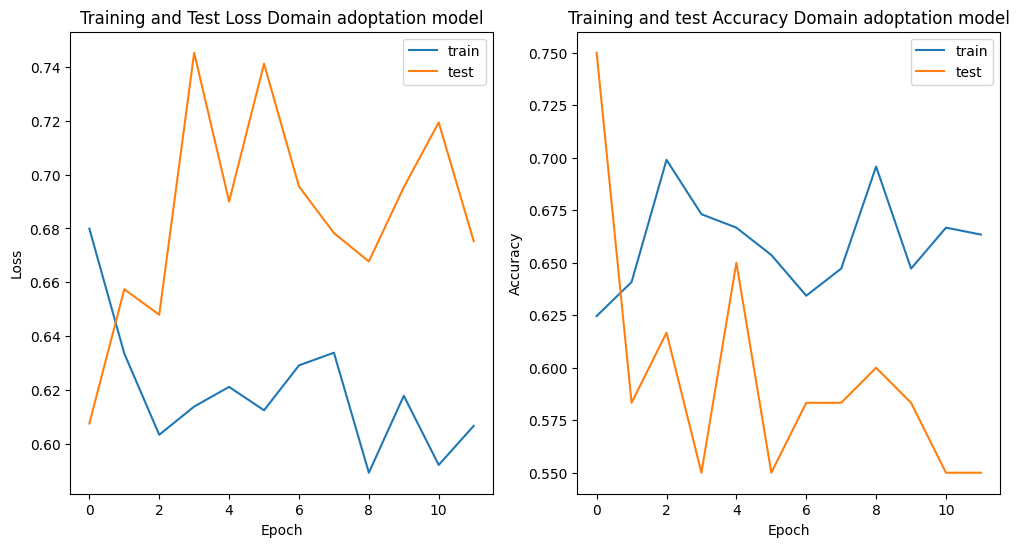

In [ ]:
# Plot the validation and training loss and accuracy values

train_val_losses = [0.6799, 0.6335, 0.6033, 0.6138, 0.6211, 0.6124, 0.6291, 0.6338, 0.5892, 0.6178, 0.5921, 0.6066]
train_val_accuracies = [0.6246, 0.6408, 0.6990, 0.6731, 0.6667, 0.6537, 0.6343, 0.6472, 0.6958, 0.6472, 0.6667, 0.6634]
test_losses = [0.6075, 0.6574, 0.6479, 0.7453, 0.6900, 0.7412, 0.6956, 0.6783, 0.6677, 0.6953, 0.7194, 0.6753]
test_accuracies = [0.7500, 0.5833, 0.6167, 0.5500, 0.6500, 0.5500, 0.5833, 0.5833, 0.6000, 0.5833, 0.5500, 0.5500]

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(train_val_losses, label='train')
ax[0].plot(test_losses, label='test')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Test Loss Domain adoptation model')
ax[0].legend()
ax[1].plot(train_val_accuracies, label='train')
ax[1].plot(test_accuracies, label='test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and test Accuracy Domain adoptation model')
ax[1].legend()
plt.show()

# Test model

In [ ]:
# load in testset
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(test_path, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

In [ ]:
model.eval()
test_loss = 0.0
y_true = []
y_pred = []
Y_pred_prob = []

with torch.no_grad():
   for i in test_loader:

          #LOAD THE DATA IN A BATCH
          data, target = i

          # moving the tensors to the configured device
          data, target = data.to(DEVICE), target.to(DEVICE)

          target = target.float()
          output = model(data.float())

          loss = criterion(output, target.unsqueeze(1))
          test_loss += loss.item() * data.size(0)


          #PREDICTIONS
          pred_prop = torch.sigmoid(output)
          pred = torch.round(torch.sigmoid(output))

          y_true.extend(target.tolist())
          y_pred.extend(pred.reshape(-1).tolist())
          Y_pred_prob.extend(pred_prop.reshape(-1).tolist())

test_loss /= len(test_loader.sampler)
test_accuracy = accuracy_score(y_true,y_pred)

# get the specificity, sensitivity and g-mean
cm = confusion_matrix(y_true, y_pred)

# Extract the elements of the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

g_mean = imblearn.metrics.geometric_mean_score(y_true, y_pred)


print()
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
f1score_macro = f1_score(y_true, y_pred, average = 'macro')
auc_roc = roc_auc_score(y_true, Y_pred_prob)

# Print the evaluation metrics
print('Test_loss:', test_loss)
print('Accuracy:', test_accuracy)
print()

print('Specificity:', specificity)
print('Sensitivity:', sensitivity)
print('g_mean:', g_mean)
print()

print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1score)
print('F1_score_macro:', f1score_macro)
print('AUC-ROC:', auc_roc)
print()

print(classification_report(y_true, y_pred))


Test_loss: 0.6752753973007202
Accuracy: 0.55

Specificity: 0.2777777777777778
Sensitivity: 0.6666666666666666
g_mean: 0.43033148291193524

Precision: 0.6829268292682927
Recall: 0.6666666666666666
F1-score: 0.674698795180723
F1_score_macro: 0.4724845327254966
AUC-ROC: 0.5582010582010581

              precision    recall  f1-score   support

         0.0       0.26      0.28      0.27        18
         1.0       0.68      0.67      0.67        42

    accuracy                           0.55        60
   macro avg       0.47      0.47      0.47        60
weighted avg       0.56      0.55      0.55        60



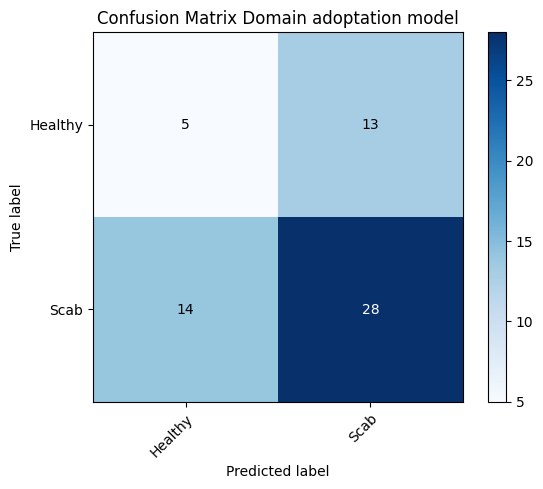

In [ ]:
import matplotlib.pyplot as plt

# Create a confusion matrix:
cm = confusion_matrix(y_true, y_pred)

# Define the class labels
classes = np.unique(['Healthy', 'Scab'])

# Create the plot
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

# Add axis labels and tick marks
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       xlabel='Predicted label',
       ylabel='True label')

# Rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2. else "black")

# Add a title and show plot
ax.set_title("Confusion Matrix Domain adoptation model")
plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()